# Deep Backward Schemes For High-Dimensional Non-Linear PDEs: Discussion of Huré et al. arXiv:1902.01599

See [the arXiv page](https://arxiv.org/abs/1902.01599).

## FBSDE Recap

$(\Omega,\mathcal{F}, \mathbb{P},(\mathcal{F}_t)_{t\in[0,T]}, W)$ stochastic basis ($W$ $d$-dimensional B.m.).

Given $$\mu\colon [0,T]\times\mathbb{R}^{n}\to\mathbb{R}^n,\quad \sigma\colon [0, T]\times\mathbb{R}^n\to\mathbb{R}^{n\times d},\quad x_{0}\in\mathbb{R}^{n}$$ and $$f\colon [0,T]\times\mathbb{R}^{n}\times\mathbb{R}^{m}\times\mathbb{R}^{m\times d}\to\mathbb{R}^{m},\quad g\colon \mathbb{R}^{n}\to\mathbb{R}^{m}$$ consider triples $(X,Y,Z)$ solving FBSDE $$dX_{t} = \mu(t, X_{t})dt + \sigma(t, X_{t})dW_{t},\quad X_{0} = x_{0}$$ and $$-dY_{t} = f(t, X_{t}, Y_{t}, Z_{t})dt - Z_{t} dW_{t},\quad Y_{t} = g(X_{T}).$$

Modulo technical conditions have $$(Y_{t}, Z_{t}) = \left(u(t, X_{t}), \nabla u(t, X_{t})^\top \sigma(t, X_{t})\right),\quad\quad (\star)$$ where $$(\partial_{t} + \mathcal{L}_{t}) u(t,x) + f(t, x, u(t,x), \nabla u(t,x)^{\top}\sigma(t,x)) = 0, \quad u(T,\cdot) = g$$ and $\mathcal{L}_{t} u(t,x) = \langle \mu(t,x),\nabla u(t,x)\rangle + \frac{1}{2}\langle \sigma^{2}(t,x),\nabla^{2} u(t,x)\rangle$.



## Discretized Backward DP Approach

For discretization choose number of steps $N$, step size $h = T/N$, and define discretization time points $t_i = i * h$ for $i=0,1,\dots, N$.
Forward discretizations ($\Delta$ indicates backward difference operator):
$$X_{t_{i+1}} = X_{t_i} + \mu(t_i, X_{t_i})\Delta t_{i+1} + \sigma(t_i, X_{t_i})\Delta W_{t_{i+1}}$$
and 
$$Y_{t_{i+1}} = Y_{t_i} - f(t_i, X_{t_i}, Y_{t_i}, Z_{t_i})\Delta t_{i+1} + Z_{t_i}\Delta W_{t_{i+1}}$$

State and control?
Combine discretizations with $(\star)$ and include *forward control* $y^f$ and *backward control* $y^b$ s.t. $$s_t = (x_t, y^f_t),\quad a_t = (y^b_t, z_t).$$

Forward control is computed using state transition function $$S_{t_{i+1}}((x, y^{f}), (y^{b}, z), \Delta w) = (x + \mu(t_{i}, x)\Delta t_{i+1} + \sigma(t_{i}, x)\Delta w, y^{b} - f(t_{i}, x, y^{b}, z) \Delta t_{i+1} + z\Delta w)$$ while for backward control leverage $(\star)$: 
Employ neural network based control functions, i.e. $$y^{b}_{t_{i}} = f^{\theta_{i}}(x_{t_{i}}),$$ and do the same for $z_{t_{i}}$ as well (or compute $z_{t_{i}}$ using representation $(\star)$ and automatic differentiation of neural network $f^{\theta_{i}}$).
Note that $f^{\theta_{i}}$ takes the role of $u(t_{i}, \cdot)$ and that the last control function is known: $u(T,\cdot) = g$.
Using backwards iterative procedure train control functions to produce a forward control that best reproduces the backward control of the next step.
Cost functions relevant to training of time-$t_i$ control:
$$L_{t_{i+1}}(s_{t_{i+1}}, a_{t_{i+1}}) = |y_{t_{i+1}}^{f} - y_{t_{i+1}}^{b}|^2$$
where $y_{t+1}$ function of time-$t_i$ control via state transition function and $y_{t_{i+1}}^{b}$ produced by time-$t_{i+1}$ control (which remains fixed).



In [1]:
import torch
from ml_adp.cost import CostToGo

Fix model parameters:

In [3]:
import math
from typing import Union

Number = Union[float, torch.Tensor]

n = 1; m = 1; d = 1
T = 1.
N = 5; h = T/N; time_discretization = torch.arange(0., T + h, h)


def mu(t: Number, x: torch.Tensor) -> torch.Tensor:
    return .2 * torch.ones(n) / n


def sigma(t: Number, x: torch.Tensor) -> torch.Tensor:
    return torch.eye(n) / math.sqrt(n)


def f(t: Number, x: torch.Tensor, y: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
    bar_x = x.sum(axis=1, keepdim=True)
    e = math.exp(.5 * (T - t))
    temp = torch.einsum('...i,...ij->...', y, z).unsqueeze(1)
    return (bar_x.cos() * (e + .5) + .2 * bar_x.sin()) * e \
        - .5 * (bar_x.sin() * bar_x.cos() * e) ** 2 \
        + .5 *  temp ** 2 / n


def g(x: torch.Tensor):
    return x.cos()



hidden_size = (10 + n, 10 + n)

Create empty `CostToGo`-object:

In [4]:
cost_to_go = CostToGo.from_number_of_steps(N)
cost_to_go

CostToGo(
 time |      state_func      |     control_func     |      cost_func       
    0                                  None                   None         
    1           None                   None                   None         
    2           None                   None                   None         
    3           None                   None                   None         
    4           None                   None                   None         
    5           None                   None                   None         
   (6)          None                                                       
)

Define state transition functions and loss functions:

In [5]:
import warnings
from typing import Tuple, Callable


class SimStep(Callable):
    def __init__(self, mu: Callable, sigma: Callable, f: Callable, t: Number, h: Number) -> None:
        super().__init__()
        self.mu = mu; self.sigma = sigma
        self.f = f
        self.t = t; self.h = h

    def __call__(self, 
                state: Tuple[torch.Tensor, torch.Tensor], 
                control: Tuple[torch.Tensor, torch.Tensor], 
                brownian_increment: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        X = state[0]; Y = control[0]; Z = control[1]
        mu = self.mu(self.t, X); sigma = self.sigma(self.t, X)
        f = self.f(self.t, X, Y, Z)

        X_next = X + mu * self.h + torch.einsum('...ij,...j->...i', sigma, brownian_increment)
        Y_next = Y - f * self.h + torch.einsum('...ij,...j->...i', Z, brownian_increment)#.unsqueeze(1)

        return X_next, Y_next


def L(state: Tuple[torch.Tensor, torch.Tensor], control: Tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
    Y_forward = state[1]
    Y_backward = control[0]
    return (Y_forward - Y_backward).square()


Set state functions and cost functions:

In [6]:
for i, t in enumerate(time_discretization[:-1]):
    cost_to_go.state_functions[i] = SimStep(mu, sigma, f, t, h)

cost_to_go.cost_functions[:] = L

cost_to_go

CostToGo(
 time |      state_func      |     control_func     |      cost_func       
    0                                  None                   L(-)         
    1        SimStep(-)                None                   L(-)         
    2        SimStep(-)                None                   L(-)         
    3        SimStep(-)                None                   L(-)         
    4        SimStep(-)                None                   L(-)         
    5        SimStep(-)                None                   L(-)         
   (6)          None                                                       
)

Define neural network based control functions:

In [7]:
from ml_adp.nn import FFN

class FKControl(torch.nn.Module):
    def __init__(self, n: int, hidden_size=(20, 20), **ffn_config) -> None:
        super().__init__()
        self.n = n
        if ffn_config.pop('size', None) is not None:  # Side effect: Removes `size`-key value
            warnings.warn('Pass size via hidden_size kwarg')
        y_net_size = (self.n, *hidden_size, m)
        z_net_size = (self.n, *hidden_size, (d, n))
        self.y_net = FFN.from_config(size=y_net_size, **ffn_config)
        self.z_net = FFN.from_config(size=z_net_size, **ffn_config)
        
    def forward(self, state: Tuple[torch.Tensor, torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor]:
        X = state[0]  
        return self.y_net(X), self.z_net(X)

Set control functions:

In [8]:
for i, t in enumerate(time_discretization[:-1]):
    cost_to_go.control_functions[i] = FKControl(n, hidden_size)

# Last one is exact, not a neural network
cost_to_go.control_functions[-1] = lambda state: (g(state[0]), None)

In [9]:
cost_to_go

CostToGo(
 time |      state_func      |     control_func     |      cost_func       
    0                            FKControl(train)             L(-)         
    1        SimStep(-)          FKControl(train)             L(-)         
    2        SimStep(-)          FKControl(train)             L(-)         
    3        SimStep(-)          FKControl(train)             L(-)         
    4        SimStep(-)          FKControl(train)             L(-)         
    5        SimStep(-)            <lambda>(-)                L(-)         
   (6)          None                                                       
)

In [10]:
from torch.distributions.normal import Normal

training_state_sampler = Normal(torch.tensor(0.), torch.tensor(10.))
brownian_increments_sampler = Normal(torch.tensor(0.), torch.tensor(h))

In [11]:
from tqdm import tqdm

sim_size = 10000

cost_to_go.train()

for time in reversed(range(cost_to_go.number_of_steps())):
    objective = cost_to_go[time:time+2]
    objective.cost_functions[0] = None
    objective.state_functions[-1] = None

    print(f"Time {time} objective:")
    print(objective)
    print(75 * "%")

    optimizer = torch.optim.Adam(params=objective.control_functions[0].parameters())

    gradient_descent_iterations = tqdm(range(300), ascii=' =')
    for iteration in gradient_descent_iterations:
        training_state = (training_state_sampler.sample((sim_size, n)), None)
        brownian_increments = brownian_increments_sampler.sample((objective.number_of_steps(), sim_size, d))

        expected_square_loss = objective(training_state, brownian_increments).mean()

        gradient_descent_iterations.set_description(
            f"Time {time} Ctrl. Opt. - MSE: {expected_square_loss:9.4f}"
        )

        expected_square_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    objective.eval()



Time 4 objective:
CostToGo(
 time |      state_func      |     control_func     |      cost_func       
    0                            FKControl(train)             None         
    1        SimStep(-)            <lambda>(-)                L(-)         
   (2)          None                                                       
)
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


Time 4 Ctrl. Opt. - MSE:    0.8717: 100%|==========| 300/300 [00:14<00:00, 20.67it/s]


Time 3 objective:
CostToGo(
 time |      state_func      |     control_func     |      cost_func       
    0                            FKControl(train)             None         
    1        SimStep(-)          FKControl(eval)              L(-)         
   (2)          None                                                       
)
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


Time 3 Ctrl. Opt. - MSE:    0.0974: 100%|==========| 300/300 [00:18<00:00, 16.48it/s]


Time 2 objective:
CostToGo(
 time |      state_func      |     control_func     |      cost_func       
    0                            FKControl(train)             None         
    1        SimStep(-)          FKControl(eval)              L(-)         
   (2)          None                                                       
)
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


Time 2 Ctrl. Opt. - MSE:    0.2434: 100%|==========| 300/300 [00:16<00:00, 17.75it/s]


Time 1 objective:
CostToGo(
 time |      state_func      |     control_func     |      cost_func       
    0                            FKControl(train)             None         
    1        SimStep(-)          FKControl(eval)              L(-)         
   (2)          None                                                       
)
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


Time 1 Ctrl. Opt. - MSE:    0.2061: 100%|==========| 300/300 [00:16<00:00, 18.10it/s]


Time 0 objective:
CostToGo(
 time |      state_func      |     control_func     |      cost_func       
    0                            FKControl(train)             None         
    1        SimStep(-)          FKControl(eval)              L(-)         
   (2)          None                                                       
)
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


Time 0 Ctrl. Opt. - MSE:    0.2641: 100%|==========| 300/300 [00:16<00:00, 18.24it/s]


In [12]:
cost_to_go

CostToGo(
 time |      state_func      |     control_func     |      cost_func       
    0                            FKControl(eval)              L(-)         
    1        SimStep(-)          FKControl(eval)              L(-)         
    2        SimStep(-)          FKControl(eval)              L(-)         
    3        SimStep(-)          FKControl(eval)              L(-)         
    4        SimStep(-)          FKControl(eval)              L(-)         
    5        SimStep(-)            <lambda>(-)                L(-)         
   (6)          None                                                       
)

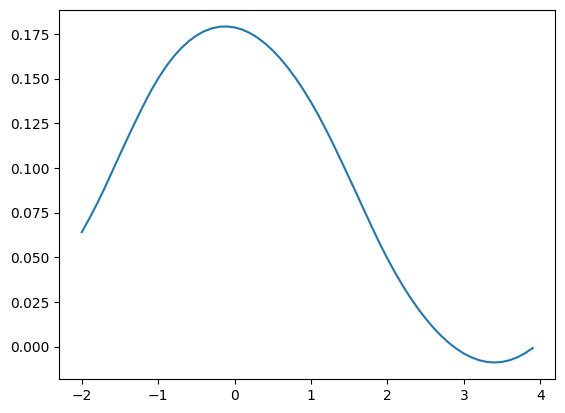

In [16]:
u = cost_to_go.control_functions[-2].y_net

xs = torch.arange(-2, 4, 0.1).unsqueeze(1)
with torch.no_grad():
    ys = [u(xs[i].unsqueeze(0)) for i in range(len(xs))]

import matplotlib.pyplot as plt

plt.plot(xs, ys)